# Script to generate routes between fed locations

Code derived from https://ipython-books.github.io/147-creating-a-route-planner-for-a-road-network/

Data(.shp file) from https://mapcruzin.com/free-delhi-country-city-place-gis-shapefiles.htm

In [1]:
import io
import os
import zipfile
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'F:\\Valerio\\Scripts and Plots\\ValerioTrials\\Geocoding')

In [3]:
def unzip_file(name):
  zipped_file = name
  zip_ref = zipfile.ZipFile(zipped_file, 'r')
  zip_ref.extractall('.')
  zip_ref.close()

In [4]:
unzip_file('delhi_highway.zip')

In [5]:
import gdal
g = nx.read_shp('delhi_highway.shp')

In [6]:
# Requires a lot of space, graph too big

# nx.draw(g)
# plt.show()

In [7]:
# Graph might not be connected, this function will yield the largest connected subgraph.
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

sgs = list(connected_component_subgraphs(g.to_undirected())) # sgs is a list of subgraphs

i = np.argmax([len(sg) for sg in sgs]) # i holds the location of the largest connected subgraph
# print(i)
sg = sgs[i] # sg is the subgraph of interest

# print(len(sg)) # number of nodes in this subgraph

In [8]:
from GeocodeAddress import geocoding
print("Enter source: ")
address = input()
pos0 = geocoding(address)
print("Enter destination: ")
address = input()
pos1 = geocoding(address)

Enter source: 
Indira Gandhi International Airport, Delhi, India
Enter destination: 
Greater Noida, India


In [9]:
print("Source entered: ", pos0)
print("Destination entered: ", pos1)

Source entered:  (28.55489735, 77.08467458266915)
Destination entered:  (28.4670734, 77.5137649)


In [10]:
def get_path(n0, n1): # n0 and n1 are tuples(containing the latitude and longitude) of the 2 locations
# returns points linking the 2 given locations
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

In [11]:
radius = 6372.8
def calcDist(lat0, lon0, lat1, lon1):
    # calculates and returns the Great-Circle Distance using the cosine formula****(in km)****
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    dlon = lon0 - lon1
    
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    
    return radius*c

In [12]:
# leverages the calcDist function to calculate the length between given 2 points
def get_path_length(path):
    return np.sum(calcDist(path[1:, 1], path[1:, 0], path[:-1, 1], path[:-1, 0])) # pass the lat and lon of the 2 points

Get Charging Stations from csv

In [13]:
df = pd.read_csv('ModifiedStations.csv')
df['location'] = list(zip(df.LATITUDE, df.LONGITUDE))

In [21]:
stations = []
for station in df.location:
    stations.append(station)
    
stations = np.array(stations) # Convert list to numpy array
    
stations = stations[:, ::-1]  # Flip the tuple from (lat, lon) to (lon, lat)
# print(stations)

station_set = set()
for val in stations:
    val = val.tolist()
    val = tuple(val)
    station_set.add(val)
    
# print(station_set)  # Set of locations of the charging stations stored as tuples.(lon, lat)

In [25]:
# Get charging station closest to the source
sourceDistToStation = 1e10
# Store the location of the station closest to the source
closestStationToSource = []

# pos0 is the user-entered source
for val in stations:
    dist = calcDist(val[1], val[0], pos0[0], pos0[1])      # User entered values are (lat, lon) all others are (lon, lat)
    if dist < sourceDistToStation:
        closestStationToSource = val
        sourceDistToStation = dist
        
print("Charging Station closest to source point entered: ", closestStationToSource)
print("Distance of the closest charging station from source(in km): ", sourceDistToStation)

Charging Station closest to source point entered:  [77.083517 28.523841]
Distance of the closest charging station from source(in km):  3.4561355700953333


In [26]:
maxDistance = None  # Max distance car can travel on current charge. To be incorporated later.
tolerance = 0.3    # How far away can a charging station be from this route(in kilometers)

def isPresent(possible, val):
    check = tuple(val)
    for loc in station_set:
        dist = calcDist(check[1], check[0], loc[1], loc[0])
        if dist <= tolerance and loc not in possible:
            possible.append(loc)
        
    return possible

In [27]:
# Check if there's a charging station closer to the destination than the source, possible optimization.

# Incorporate the range information later, for now, assume the car can get to the destination without needing a recharge.

destDistToStation = 1e10
closestStationToDest = []

# find the closest station to the destination.
for val in stations:
    dist = calcDist(val[1], val[0], pos1[0], pos1[1])
    if dist < destDistToStation:
        closestStationToDest = val
        destDistToStation = dist
        
print("Charging Station closest to destination point entered: ", closestStationToDest)
print("Distance of the closest charging station from destination(in km): ", destDistToStation)

Charging Station closest to destination point entered:  [77.27077 28.53764]
Distance of the closest charging station from destination(in km):  25.014891635522087


Now all the distances and 2 possible charging stations are available to us.
After building the graph, decide which station is the better option, 
based on the total distance that'll get travelled going via each of the 2 stations, one at a time.

Build graph

In [28]:
# Update the graph edges by assigning them actual distance

possible = [] # possible charging stations all of which lie on the route.

for n0, n1 in sg.edges:
    path = get_path(n0, n1) # will return numpy array of points, path is a list of lats and lons each returned in a list format, hence a list of lists.
    
    # Add a check to see if returned array of points has any charging stations....
    for val in path:
        possible = isPresent(possible, val)
    
    # print(path)
    # print("End of a segment")
    
    dist = get_path_length(path)
    sg.edges[n0, n1]['distance'] = dist # update step
    


# print(possible)

# possible is non-empty for atleast 300m tolerance value, i.e., there is no point in our list of 'nodes' that is closer
# to a charging station than 300m.

In [29]:
# Our requested positions might not be on the graph, find the locations on the graph closest to them

# print(sg.edges)   # list of nested tuples.
# print(sg.nodes)   # list of nodes.
# print(len(sg))    # Number of nodes in this subgraph.

# get all the nodes of the constructed graph into an array and find the point closest to target point.
nodes = np.array(sg.nodes)
# print("Nodes array: ", nodes) # list of latitudes and longitudes(Total 278 datapoints)(latitudes and longitudes are stored as list and not tuple)
#  Nodes are also stored as (lon, lat).

In [30]:
def getClosestPointIndex(loc):
    loc_i = np.argmin(np.sum((nodes[:, ::-1] - loc)**2, axis=1))
    return loc_i

In [32]:
# Get the closest nodes in the graph. source_i and destination_i return index of the points closest to requested points in the nodes array
source_i = getClosestPointIndex(pos0)
destination_i = getClosestPointIndex(pos1)
# Get the points closest to the 2 charging stations.
source_station_i = np.argmin(np.sum((nodes - closestStationToSource)**2, axis=1))
dest_station_i = np.argmin(np.sum((nodes - closestStationToDest)**2, axis=1))


print("Source, Closest charging station from source, Closest charging station from destination and Destination indices: ", source_i, source_station_i, dest_station_i, destination_i)

Source, Closest charging station from source, Closest charging station from destination and Destination indices:  139 268 79 100


Instantiate the map 

In [33]:
m = smopy.Map(pos0, pos1, z=7, margin=.1)

In [34]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

Compute the total path lengths in the 2 cases for selecting one out of the 2 possible charging station.

In [44]:
# Shortest path length for case 1: choose the charging station closest to the source point.
dist1 = nx.shortest_path_length(sg, 
                                source = tuple(nodes[source_i]), 
                                target = tuple(nodes[source_station_i]),
                                weight = 'distance')
dist2 = nx.shortest_path_length(sg,
                                source = tuple(nodes[source_station_i]),
                                target = tuple(nodes[destination_i]),
                                weight = 'distance')
print("Total distance(in km) in case 1: ", dist1+dist2)

Total distance(in km) in case 1:  96.9494611310185


In [45]:
# Shortest path length for case 2: choose the charging station closest to the destination point.
dist3 = nx.shortest_path_length(sg, 
                                source = tuple(nodes[source_i]), 
                                target = tuple(nodes[dest_station_i]),
                                weight = 'distance')
dist4 = nx.shortest_path_length(sg,
                                source = tuple(nodes[dest_station_i]),
                                target = tuple(nodes[destination_i]),
                                weight = 'distance')
print("Total distance(in km) in case 1: ", dist3+dist4)

Total distance(in km) in case 1:  83.77617608947672


In [50]:
# Find the minimum.
if(dist3+dist4 < dist1+dist2):
    station_i = dest_station_i
else:
    station_i = source_station_i

In [51]:
print("Hence we will have to cover lesser distance if go to the charging station at: ", nodes[station_i])

Hence we will have to cover lesser distance if go to the charging station at:  [77.2832768 28.5385957]


Now that we have chosen which charging station we want to visit, build the route accordingly.

In [62]:
# Compute the shortest path from source to the charging station closest to source point.
path1 = nx.shortest_path(
    sg,
    source=tuple(nodes[source_i]),
    target=tuple(nodes[station_i]),
    weight='distance')  # Computes the shortest path (weighted by distance).

# Compute the shortest path from charging station closest to source point to destination.
path2 = nx.shortest_path(
    sg,
    source=tuple(nodes[station_i]),
    target=tuple(nodes[destination_i]),
    weight='distance')

# path = path1+path2 # is the final path from source->nearest charging station->destination
# print("Path 1: ", path1)
# print("Path 2: ", path2)
# print("Path: ", path)
# The path variable now contains the list of edges that form the shortest path between requested positions
# print(len(path))

In [63]:
# Get the co-ordinates of the approximate source, charging station and destination:
print("Source: ", nodes[source_i])
print("Station: ", nodes[station_i])
print("Destination: ", nodes[destination_i])

Source:  [77.0800163 28.6304438]
Station:  [77.2832768 28.5385957]
Destination:  [77.4375113 28.5313274]


In [64]:
if source_i != station_i:
    linepath = get_full_path(path1)
#     print(linepath)
    a, b = m.to_pixels(linepath[:, 1], linepath[:, 0])
    
else:
    print("There's a charging station right where you are !")
    
# # print(len(a))
# # print(len(b))

In [65]:
linepath = get_full_path(path2)
# print(linepath)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

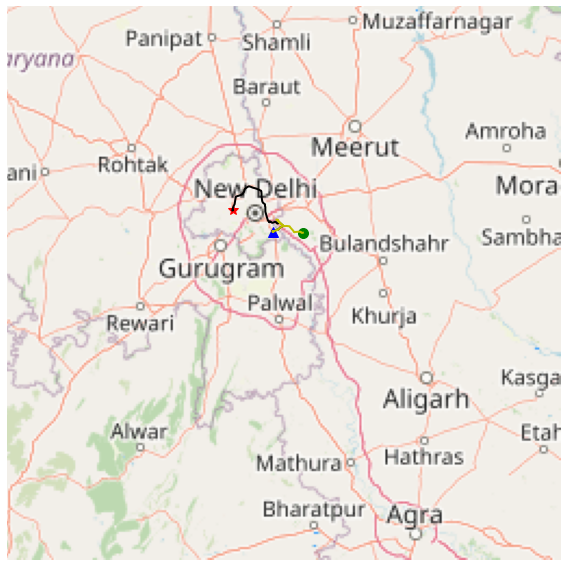

In [66]:
ax = m.show_mpl(figsize=(8, 8))

# Mark our positions.(Source->Station->Destination : RBG)
if source_i != station_i:
    ax.plot(a[0], b[0], 'or', ms=10, marker='*')  # Source is marked with a star * in red.

# ax.plot(a[-1], b[-1], 'oy', ms=10)
ax.plot(x[0], y[0], 'ob', ms=10, marker='^')  # Charging station is marked with a ^ in blue.
ax.plot(x[-1], y[-1], 'og', ms=10)            # Destination is marked with a . in green.

# Mark the 2 paths, first from source to closest charging station and then from there on to the destination.
if source_i != station_i:
    ax.plot(a, b, '-k', lw=2) # Source to station is marked with black.

ax.plot(x, y, '-y', lw=2) # Station to destination is marked with yellow.

# NOTE: If the black and yellow lines overlap, yellow will be seen.